In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from bnn import BNN

import matplotlib.pyplot as plt

tfd = tfp.distributions

data_dir = "/scratch/gf332/Misc/datasets/"

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
mnist = tfds.load("mnist", data_dir=data_dir)

In [4]:
model_save_dir = "/scratch/gf332/Misc/bnn_experiments/bnn"

In [5]:
model = BNN()
model.build(input_shape=(1, 28, 28, 1))

ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)#.expect_partial()
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from /scratch/gf332/Misc/bnn_experiments/bnn/ckpt-138


tf.Tensor(
[[8.8955928e-04 4.4752736e-07 2.2298316e-06 1.5765008e-07 2.8720076e-04
  7.4384287e-02 9.2281157e-01 9.5690403e-08 1.2518546e-03 3.7260409e-04]], shape=(1, 10), dtype=float32)
Actual:  6
Prediction: 6


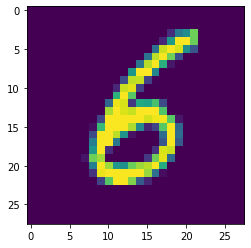

In [6]:
test_ds = mnist['test']
test_ds = test_ds.map(lambda x: (tf.cast(x["image"], tf.float32) / 255., x["label"])).shuffle(300)

for im, label in test_ds.batch(1).take(1):
    
    plt.imshow(im[0, ..., 0])
    
    probs = model(im)
    
    print(probs)
    
    print("Actual: ", label[0].numpy())
    print("Prediction:", tf.argmax(probs, axis=1)[0].numpy())

In [7]:
test_accuracy = 0.
total_size = 0.

batch_size = 500

for im, label in test_ds.batch(batch_size).take(1):
    
    probs = model(im)
    
    test_accuracy += tf.reduce_sum(tf.cast(tf.argmax(probs, axis=1) == label, tf.float32))
    
    total_size += tf.cast(label.shape[0], tf.float32)
    
test_accuracy = test_accuracy / total_size

In [8]:
test_accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.922>